<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Package" data-toc-modified-id="Import-Package-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Package</a></span></li><li><span><a href="#Multi-way-AND-function" data-toc-modified-id="Multi-way-AND-function-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Multi-way AND function</a></span><ul class="toc-item"><li><span><a href="#Verify-figure-5" data-toc-modified-id="Verify-figure-5-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Verify figure 5</a></span></li><li><span><a href="#Simulate-random-forest" data-toc-modified-id="Simulate-random-forest-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Simulate random forest</a></span></li></ul></li><li><span><a href="#Simulate-a-figure-similar-to-figure-4-with-2,-3,-4-ways-and-use-random-forest-average-as-explanation-score" data-toc-modified-id="Simulate-a-figure-similar-to-figure-4-with-2,-3,-4-ways-and-use-random-forest-average-as-explanation-score-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simulate a figure similar to figure 4 with 2, 3, 4 ways and use random forest average as explanation score</a></span><ul class="toc-item"><li><span><a href="#fit-model-with-a-single-tree" data-toc-modified-id="fit-model-with-a-single-tree-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>fit model with a single tree</a></span></li><li><span><a href="#fit-model-with-a-random-forest" data-toc-modified-id="fit-model-with-a-random-forest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>fit model with a random forest</a></span></li></ul></li><li><span><a href="#Multi-way-OR-function" data-toc-modified-id="Multi-way-OR-function-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multi-way OR function</a></span><ul class="toc-item"><li><span><a href="#fit-model-with-a-single-tree" data-toc-modified-id="fit-model-with-a-single-tree-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>fit model with a single tree</a></span></li><li><span><a href="#fit-model-with-a-random-forest" data-toc-modified-id="fit-model-with-a-random-forest-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>fit model with a random forest</a></span></li></ul></li></ul></div>

27.01.2022 Note

1. After randomization, both AND and OR function shows that Saabas and Shap is practically similar
2. The only problem that need to be considered is the sum of Saabas and Shap over all features are not definitely 1 if we don't set up the max_depth. But if we set max_depth is i, then the sum is way smaller than 1 in 2 way. -> Randomization

# Import Package

The codes references the Saabas Inconsistencies.ipynb from https://github.com/suinleelab/treeexplainer-study/tree/master/notebooks

In [2]:
import shap
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as pl
from sklearn.tree import DecisionTreeRegressor
import numpy as np
#import graphviz
from treeinterpreter import treeinterpreter as ti
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import random



# Multi-way AND function

## Verify figure 5

In [3]:
def multiwayand(display=False, and_size=2, extra_features=0):
    M = and_size + extra_features # number of features
    N = 2**M # number of observations
    
    X = np.zeros((N,M)) # a matrix (N * M)
    def rec(X, start, end, depth):
        if depth >= X.shape[1]: return
        half = (start + end) // 2
        X[start:half,depth] = 1
        rec(X, start, half, depth + 1) # Recursive Functions
        rec(X, half, end, depth + 1)

    rec(X, 0, N, 0)
    y = np.zeros(N)
    
    y[X[:,:and_size].sum(1) == and_size] = 1
    
    return X, y


In [4]:
def corroborate_Figure5(and_size, extra_features, m):

    X,y = multiwayand(and_size = and_size, extra_features = extra_features) # Fever-Cough occassion
    print("X is")
    print(X)
    print()
    print("y is")
    print(y)
    print()
    if m == "A":
        y[(X[:,0]==1.) & (X[:,1]==1.)] = 80 # Model A
    if m == "B":
        y[(X[:,0]==1.) & (X[:,1]==1.)] = 90 # Model B
        y[(X[:,0]==1.) & (X[:,1]==0.)] = 10
    print("y is")
    print(y)
    model = sklearn.tree.DecisionTreeRegressor(max_depth=2, max_features = 1)
    model.fit(X, y)
    
    shap_values = shap.TreeExplainer(model).shap_values(X)
    print("Tree SHAP is ",shap_values)
    
    shap_all = shap.Explainer(model)
    print("SHAP all is ",shap_all(X))
    
    pred, bias, cfc = ti.predict(model, X) # tree interpreter values
    print("Saabas by ti is ",cfc)
    
    saabas_values = shap.TreeExplainer(model).shap_values(X, approximate=True)
    print("Saabas by shap_app_T is ",saabas_values)
    
    return X,shap_values, cfc

In [4]:
X_A, shap_values_A, cfc_A = corroborate_Figure5(2,0,"A") # check the Figure 5 Model A
shap_values_A, cfc_A

X is
[[1. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]]

y is
[1. 0. 0. 0.]

y is
[80.  0.  0.  0.]
Tree SHAP is  [[ 30.  30.]
 [ 10. -30.]
 [-30.  10.]
 [-10. -10.]]
SHAP all is  .values =
array([[ 30.,  30.],
       [ 10., -30.],
       [-30.,  10.],
       [-10., -10.]])

.base_values =
array([[20.],
       [20.],
       [20.],
       [20.]])

.data =
array([[1., 1.],
       [1., 0.],
       [0., 1.],
       [0., 0.]])
Saabas by ti is  [[ 20.  40.]
 [ 20. -40.]
 [-20.   0.]
 [-20.   0.]]
Saabas by shap_app_T is  [[ 20.  40.]
 [ 20. -40.]
 [-20.   0.]
 [-20.   0.]]


(array([[ 30.,  30.],
        [ 10., -30.],
        [-30.,  10.],
        [-10., -10.]]),
 array([[ 20.,  40.],
        [ 20., -40.],
        [-20.,   0.],
        [-20.,   0.]]))

In [5]:
# Average each feature
print(shap_values_A.mean(axis = 0))
print(cfc_A.mean(axis = 0))

# Average each feature
print((X_A * shap_values_A).mean(axis = 0))
print((X_A *cfc_A).mean(axis = 0))

[0. 0.]
[0. 0.]
[10. 10.]
[10. 10.]


In [6]:
X_B, shap_values_B, cfc_B =corroborate_Figure5(2,0,"B") # check the Figure 5 Model B
shap_values_B, cfc_B

X is
[[1. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]]

y is
[1. 0. 0. 0.]

y is
[90. 10.  0.  0.]
Tree SHAP is  [[ 35.  30.]
 [ 15. -30.]
 [-35.  10.]
 [-15. -10.]]
SHAP all is  .values =
array([[ 35.,  30.],
       [ 15., -30.],
       [-35.,  10.],
       [-15., -10.]])

.base_values =
array([[25.],
       [25.],
       [25.],
       [25.]])

.data =
array([[1., 1.],
       [1., 0.],
       [0., 1.],
       [0., 0.]])
Saabas by ti is  [[ 25.  40.]
 [ 25. -40.]
 [-25.   0.]
 [-25.   0.]]
Saabas by shap_app_T is  [[ 25.  40.]
 [ 25. -40.]
 [-25.   0.]
 [-25.   0.]]


(array([[ 35.,  30.],
        [ 15., -30.],
        [-35.,  10.],
        [-15., -10.]]),
 array([[ 25.,  40.],
        [ 25., -40.],
        [-25.,   0.],
        [-25.,   0.]]))

In [7]:
# Average each feature
print(shap_values_B.mean(axis = 0))
print(cfc_B.mean(axis = 0))

# x * each feature then average
print((X_B * shap_values_B).mean(axis = 0))
print((X_B *cfc_B).mean(axis = 0))

[0. 0.]
[0. 0.]
[12.5 10. ]
[12.5 10. ]


But if we average each feature, both in SHAP and Saabas Fever and Cough are equally important in this simple even data.

## Simulate random forest

- cough, fever 800 dataset (even)
- 100 trees in random forest (ntry = 1)
- ti and shap for each feature

In [5]:
def multiwayand2(display=False, and_size=2, extra_features=0, obsn=800):
    M = and_size + extra_features # number of features
    N = obsn # number of observations
    
    X = np.zeros((N,M)) # a matrix (N * M)
    def rec(X, start, end, depth):
        if depth >= X.shape[1]: return
        half = (start + end) // 2
        X[start:half,depth] = 1
        rec(X, start, half, depth + 1) # Recursive Functions
        rec(X, half, end, depth + 1)

    rec(X, 0, N, 0)
    y = np.zeros(N)
    
    y[X[:,:and_size].sum(1) == and_size] = 1
    
    return X, y


In [9]:
def mysimulation1(m):

    X,y = multiwayand2(and_size = 2, extra_features = 0, obsn=800)

    if m == "A":
        y[(X[:,0]==1.) & (X[:,1]==1.)] = 80 # Model A
    if m == "B":
        y[(X[:,0]==1.) & (X[:,1]==1.)] = 90 # Model B
        y[(X[:,0]==1.) & (X[:,1]==0.)] = 10
    rf = RandomForestRegressor(max_features = 1, n_estimators = 100)
    # max_features = mtry = 1
    rf.fit(X,y)
    
    # all trees
    j=0
    shap_values = []
    saabas_values = []
    for tree in rf.estimators_:
        shap_values.append(shap.TreeExplainer(tree).shap_values(X[(X[:,0]==1.) & (X[:,1]==1.)]).mean(axis = 0))

        saabas_values.append(shap.TreeExplainer(tree).shap_values(X[(X[:,0]==1.) & (X[:,1]==1.)], approximate=True).mean(axis = 0))

        j=j+1

    
    return np.mean(shap_values, axis = 0), np.mean(saabas_values, axis = 0)

In [10]:
#random.seed(0)
shapA, tiA = mysimulation1("A")
shapB, tiB = mysimulation1("B")

In [11]:
print(shapA, tiA) # [ 30.,  30.], [ 20.,  40.]

[29.99323298 30.06376702] [29.17146596 30.88553404]


In [12]:
print(shapB, tiB) # [ 35.,  30.], [ 25.  40.]

[34.91191094 29.97146406] [35.07544689 29.80792811]


# Simulate a figure similar to figure 4 with 2, 3, 4 ways and use random forest average as explanation score

## fit model with a single tree

In [6]:
# don't need to run again

saabas_values_arr = []
shap_values_arr = []
for i in range(2,11):
    X,y = multiwayand(and_size=i, extra_features=10-i)
#    print(i)
#    print(X)
#    print(y)
    y[y == 0] = -y.sum()/(y == 0).sum()
    model = sklearn.tree.DecisionTreeRegressor(max_depth=i,random_state=50) # it doesn't matter though
    model.fit(X, y)
    
   # print(y.mean())
    shap_values = shap.TreeExplainer(model).shap_values(X[0:1,:])
    shap_values_arr.append(shap_values)
    saabas_values = shap.TreeExplainer(model).shap_values(X[0:1,:], approximate=True)
    saabas_values_arr.append(saabas_values)
#     print(X[0,:])
#    print(shap.TreeExplainer(model).shap_values(X[0:1,:]))
#    print(shap.TreeExplainer(model).shap_values(X[0:1,:], approximate=True))

#print(saabas_values_arr)


In [7]:
# don't need to run again

# change to dataframe
shap_values_arr = pd.DataFrame({"2way":shap_values_arr[0][0],
            "3way":shap_values_arr[1][0],
            "4way":shap_values_arr[2][0],
            "5way":shap_values_arr[3][0],
            "6way":shap_values_arr[4][0],
            "7way":shap_values_arr[5][0],
            "8way":shap_values_arr[6][0],
            "9way":shap_values_arr[7][0],
            "10way":shap_values_arr[8][0]})
saabas_values_arr = pd.DataFrame({"2way":saabas_values_arr[0][0],
            "3way":saabas_values_arr[1][0],
            "4way":saabas_values_arr[2][0],
            "5way":saabas_values_arr[3][0],
            "6way":saabas_values_arr[4][0],
            "7way":saabas_values_arr[5][0],
            "8way":saabas_values_arr[6][0],
            "9way":saabas_values_arr[7][0],
            "10way":saabas_values_arr[8][0]})

In [8]:
# don't need to run again

#save shap_values_arr, saabas_values_arr to files
# so we do not have rerun each time

shap_values_arr.to_csv(Path.cwd().parent.joinpath("/Data/shap_values_arr.csv"))
saabas_values_arr.to_csv(Path.cwd().parent.joinpath("/Data/saabas_values_arr.csv"))

In [9]:
# start from this

shap_values_arr = pd.read_csv(Path.cwd().parent.joinpath("/Data/shap_values_arr.csv"),).iloc[:,1:]
saabas_values_arr = pd.read_csv(Path.cwd().parent.joinpath("/Data/saabas_values_arr.csv"),).iloc[:,1:]

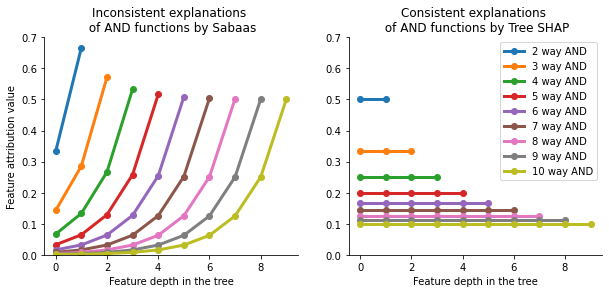

In [10]:
f = pl.figure(figsize=(10,4))
pl.subplot(1,2,1)
for i in range(len(saabas_values_arr)-1):
    pl.plot(
        list(range(0,i+2)), sorted(saabas_values_arr.iloc[:,i][:i+2]), ".-",
        markersize=12, label=str(i+2)+" way AND", linewidth=3,
       # color=shap.plots.colors.red_blue_solid(i * 1.0/8)
    )
pl.ylabel("Feature attribution value")
pl.xlabel("Feature depth in the tree")
#pl.legend()
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('left')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)
pl.ylim(0,0.7)
pl.title("Inconsistent explanations \n of AND functions by Sabaas")

pl.subplot(1,2,2) 
for i in range(len(shap_values_arr)-1):
    pl.plot(
        list(range(0,i+2)), sorted(shap_values_arr.iloc[:,i][:i+2]), ".-",
        markersize=12, label=str(i+2)+" way AND", linewidth=3,
       # color=shap.plots.colors.red_blue_solid(i * 1.0/8)
    )
#pl.ylabel("SHAP feature attribution value")
pl.xlabel("Feature depth in the tree")
pl.legend()
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('left')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)
pl.title("Consistent explanations \n of AND functions by Tree SHAP")
pl.ylim(0,0.7)
#pl.colorbar()
pl.savefig(Path.cwd().parent.joinpath("/Figures/Fig1_multiway_and.pdf"))
pl.show()

## fit model with a random forest

In [12]:
# don't need to run again

# default obsn
saabas_values_rf = []
shap_values_rf = []
for i in range(2,11):
    X,y = multiwayand(and_size=i, extra_features=10-i)
    #print(i)
    #print(X)
    #print(y)
    y[y == 0] = -y.sum()/(y == 0).sum()

    # model = sklearn.tree.DecisionTreeRegressor()
    rf = RandomForestRegressor(max_features = int(np.round(np.sqrt(i-1))), 
                               random_state=50, n_estimators = 100)
    # max_features = mtry = 1; 
    # if max_depth=i, there is a problem
    rf.fit(X,y)
    
    # all trees
    j=0
    shap_values = []
    saabas_values = []
    for tree in rf.estimators_:
        shap_values.append(shap.TreeExplainer(tree).shap_values(X[0:1,:]).mean(axis = 0))
        saabas_values.append(shap.TreeExplainer(tree).shap_values(X[0:1,:], approximate=True).mean(axis = 0))

        j=j+1

    shap_values_rf.append(np.mean(shap_values, axis = 0))
    saabas_values_rf.append(np.mean(saabas_values, axis = 0))
#     print(y.mean())
#    print("shap value: ", shap_values_rf)
#    print("saabas value: ", saabas_values_rf)
#    print(X[0,:])


In [13]:
# don't need to run again

# change to dataframe

shap_values_rf = pd.DataFrame({"2way":shap_values_rf[0],
            "3way":shap_values_rf[1],
            "4way":shap_values_rf[2],
            "5way":shap_values_rf[3],
            "6way":shap_values_rf[4],
            "7way":shap_values_rf[5],
            "8way":shap_values_rf[6],
            "9way":shap_values_rf[7],
            "10way":shap_values_rf[8]})
saabas_values_rf = pd.DataFrame({"2way":saabas_values_rf[0],
            "3way":saabas_values_rf[1],
            "4way":saabas_values_rf[2],
            "5way":saabas_values_rf[3],
            "6way":saabas_values_rf[4],
            "7way":saabas_values_rf[5],
            "8way":saabas_values_rf[6],
            "9way":saabas_values_rf[7],
            "10way":saabas_values_rf[8]})


In [14]:
#save shap_values_rf, saabas_values_rf to files
# so we do not have rerun each time

shap_values_rf.to_csv(Path.cwd().joinpath("shap_values_rf.csv"))
saabas_values_rf.to_csv(Path.cwd().joinpath("saabas_values_rf.csv"))

In [15]:
# start from this

shap_values_rf = pd.read_csv(Path.cwd().joinpath("shap_values_rf.csv"),).iloc[:,1:]
saabas_values_rf = pd.read_csv(Path.cwd().joinpath("saabas_values_rf.csv"),).iloc[:,1:]

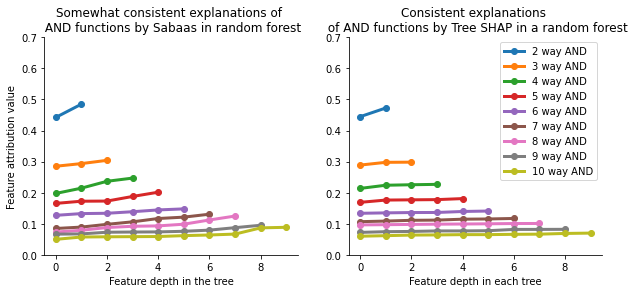

In [16]:
print()
f = pl.figure(figsize=(10,4))
pl.subplot(1,2,1)
for i in range(len(saabas_values_rf)-1):
    pl.plot(
        list(range(0,i+2)), sorted(saabas_values_rf.iloc[:,i][:i+2]), ".-",
        markersize=12, label=str(i+2)+" way AND", linewidth=3,
       # color=shap.plots.colors.red_blue_solid(i * 1.0/8)
    )
pl.ylabel("Feature attribution value")
pl.xlabel("Feature depth in the tree")
#pl.legend()
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('left')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)
pl.ylim(0,0.7)
pl.title("Somewhat consistent explanations of \n AND functions by Sabaas in random forest")

pl.subplot(1,2,2) 
for i in range(len(shap_values_rf)-1):
    pl.plot(
        list(range(0,i+2)), sorted(shap_values_rf.iloc[:,i][:i+2]), ".-",
        markersize=12, label=str(i+2)+" way AND", linewidth=3,
       # color=shap.plots.colors.red_blue_solid(i * 1.0/8)
    )
#pl.ylabel("SHAP feature attribution value")
pl.xlabel("Feature depth in each tree")
pl.legend()
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('left')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)
pl.title("Consistent explanations \n of AND functions by Tree SHAP in a random forest")
pl.ylim(0,0.7)
#pl.colorbar()
pl.savefig(Path.cwd().parent.joinpath("/Figures/Fig2_multiway_and_rf.pdf"))
pl.show()

In [23]:
# The ways to select from the final saabas/shap list are different
print(i)
print(saabas_values_arr[i])
print(saabas_values_rf[i])
print(saabas_values_arr[i][0,:2])
print(saabas_values_rf[i][:2])

8
[[0.06256109 0.25024438 0.12512219 0.00782014 0.00195503 0.03128055
  0.01564027 0.00097752 0.00391007 0.50048876]]
[0.05883043 0.05841907 0.05725261 0.06168665 0.06379423 0.0885171
 0.06669711 0.04975017 0.08672942 0.05798108]
[0.06256109 0.25024438]
[0.05883043 0.05841907]


- 2, 3, 4 ways 
- random forest average
- explanation to the logic of codes
- or

# Multi-way OR function

In [24]:
def multiwayor(display=False, or_size=2, extra_features=0):
    M = or_size + extra_features
    N = 2**M
    
    X = np.zeros((N,M))
    def rec(X, start, end, depth):
        if depth >= X.shape[1]: return
        half = (start + end) // 2
        X[start:half,depth] = 1
        rec(X, start, half, depth + 1)
        rec(X, half, end, depth + 1)
    rec(X, 0, N, 0)
    y = np.zeros(N)
    y[X[:,:or_size].sum(1) > 0] = 1
    return X, y


In [25]:
X,y = multiwayor(or_size=2, extra_features=2)
X

array([[1., 1., 1., 1.],
       [1., 1., 1., 0.],
       [1., 1., 0., 1.],
       [1., 1., 0., 0.],
       [1., 0., 1., 1.],
       [1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 1., 1.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]])

In [26]:
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.])

## fit model with a single tree

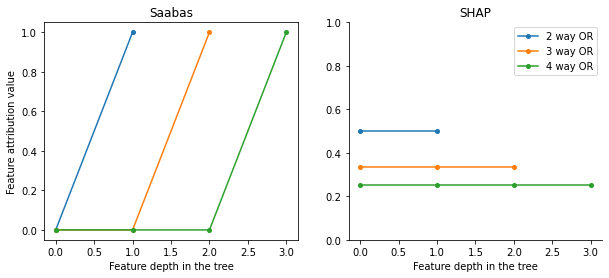

In [27]:
# fit model
saabas_values_arr = []
shap_values_arr = []
for i in range(2,5):
    X,y = multiwayor(or_size=i, extra_features=4-i)
    y[y == 0] = -y.sum()/(y == 0).sum()
    model = sklearn.tree.DecisionTreeRegressor(max_depth=i)
    model.fit(X, y)
    
#     print(y.mean())

    shap_values = shap.TreeExplainer(model).shap_values(X[0:1,:])
    shap_values_arr.append(shap_values)
    saabas_values = shap.TreeExplainer(model).shap_values(X[0:1,:], approximate=True)
    saabas_values_arr.append(saabas_values)
#     print(X[0,:])
#    print("shap", shap.TreeExplainer(model).shap_values(X[0:1,:]))
#    print("saabas", shap.TreeExplainer(model).shap_values(X[0:1,:], approximate=True))

f = pl.figure(figsize=(10,4))
pl.subplot(1,2,1)
for i in range(len(saabas_values_arr)):
    pl.plot(
        list(range(0,i+2)), sorted(saabas_values_arr[i][0,:i+2]), ".-",
        markersize=8, label=str(i+2)+" way OR",
       # color=shap.plots.colors.red_blue_solid(i * 1.0/8)
    )
pl.ylabel("Feature attribution value")    
pl.xlabel("Feature depth in the tree") 
#pl.legend()
pl.title("Saabas")

pl.subplot(1,2,2) 
for i in range(len(shap_values_arr)):
    pl.plot(
        list(range(0,i+2)), sorted(shap_values_arr[i][0,:i+2]), ".-",
        markersize=8, label=str(i+2)+" way OR",
       # color=shap.plots.colors.red_blue_solid(i * 1.0/8)
    )
pl.xlabel("Feature depth in the tree")
pl.legend()
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('left')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)
pl.title("SHAP")
pl.ylim(0,1)
pl.show()

In [28]:
# check why the saabas is shown like this
for i in range(3):
    print(i)
    print(saabas_values_arr[i])
    print(saabas_values_arr[i][0,:i+2])
    print(shap_values_arr[i])
    print(shap_values_arr[i][0,:i+2])

0
[[0. 1. 0. 0.]]
[0. 1.]
[[0.5 0.5 0.  0. ]]
[0.5 0.5]
1
[[0. 1. 0. 0.]]
[0. 1. 0.]
[[0.33333333 0.33333333 0.33333333 0.        ]]
[0.33333333 0.33333333 0.33333333]
2
[[1. 0. 0. 0.]]
[1. 0. 0. 0.]
[[0.25 0.25 0.25 0.25]]
[0.25 0.25 0.25 0.25]


In [29]:
list(range(0,1+2)), sorted(saabas_values_arr[i][0,:1+2])

([0, 1, 2], [0.0, 0.0, 1.0])

In [30]:
saabas_values_arr[i][0,:i+2]

array([1., 0., 0., 0.])

##  fit model with a random forest

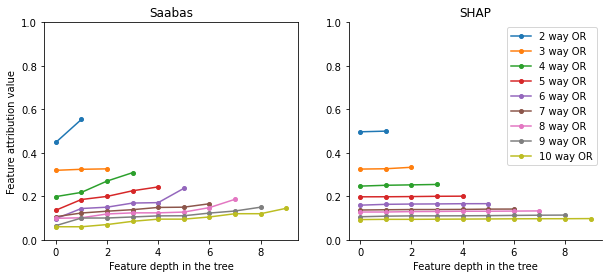

In [31]:
# fit model
saabas_values_rf = []
shap_values_rf = []
for i in range(2,11):
    X,y = multiwayor(or_size=i, extra_features=10-i)
    y[y == 0] = -y.sum()/(y == 0).sum()
    rf = RandomForestRegressor(max_features = int(np.round(np.sqrt(i-1))), n_estimators = 200)
    # max_features = mtry = 1; 
    # if max_depth=i, there is a problem
    rf.fit(X,y)
    
    # all trees
    j=0
    shap_values = []
    saabas_values = []
    for tree in rf.estimators_:
        shap_values.append(shap.TreeExplainer(tree).shap_values(X[0:1,:]).mean(axis = 0))
        saabas_values.append(shap.TreeExplainer(tree).shap_values(X[0:1,:], approximate=True).mean(axis = 0))

        j=j+1

    shap_values_rf.append(np.mean(shap_values, axis = 0))
    saabas_values_rf.append(np.mean(saabas_values, axis = 0))
#     print(y.mean())
#    print("shap value: ", shap_values_rf)
#    print("saabas value: ", saabas_values_rf)
#    print(X[0,:])
print()
f = pl.figure(figsize=(10,4))
pl.subplot(1,2,1)
for i in range(len(saabas_values_rf)):
    pl.plot(
        list(range(0,i+2)), sorted(saabas_values_rf[i][:i+2]), ".-",
        markersize=8, label=str(i+2)+" way OR",
       # color=shap.plots.colors.red_blue_solid(i * 1.0/8)
    )
pl.ylabel("Feature attribution value")    
pl.xlabel("Feature depth in the tree") 
pl.ylim(0,1)
#pl.legend()
pl.title("Saabas")

pl.subplot(1,2,2) 
for i in range(len(shap_values_rf)):
    pl.plot(
        list(range(0,i+2)), sorted(shap_values_rf[i][:i+2]), ".-",
        markersize=8, label=str(i+2)+" way OR",
       # color=shap.plots.colors.red_blue_solid(i * 1.0/8)
    )
pl.xlabel("Feature depth in the tree")
pl.legend()
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('left')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)
pl.title("SHAP")
pl.ylim(0,1)
pl.show()

- Sage: https://github.com/iancovert/sage